### Student Information
Name:張哲緯

Student ID:112033628

GitHub ID:cheweiiii1109

Kaggle name:weeeeee111

Kaggle private scoreboard snapshot: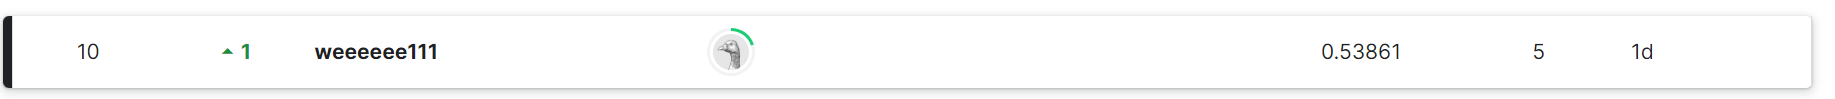

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

In [2]:
### Begin Assignment Here


I use ktrain to build & train the ML model.

In [ ]:
!pip install ktrain
import ktrain
from ktrain import text

## Data Preprocess
Split the training data into training data and validation data.

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

data = []
with open('/kaggle/input/dm2023/tweets_DM.json') as f:
    for line in f:
        tweet = json.loads(line)['_source']['tweet']
        data.append((tweet['tweet_id'], tweet['text']))

df = pd.DataFrame.from_records(data, columns=['tweet_id', 'text'])

# merge with emotion and identification
df_emotion = pd.read_csv('/kaggle/input/dm2023/emotion.csv')
df_identification = pd.read_csv(
    '/kaggle/input/dm2023/data_identification.csv')
df = df.merge(df_identification, how="outer")
df = df.merge(df_emotion, how="outer")

df_train = df[df['identification'] == 'train']
df_test = df[df['identification'] == 'test']

# 80% for training and others for validation
train, validate = train_test_split(df_train, test_size=0.1)
train.to_csv('./train.csv', index=False)
validate.to_csv('./validate.csv', index=False)
df_test.to_csv('./test.csv', index=False)

## Preparae Data 

In [ ]:
# load data 
import pandas as pd
df_train = pd.read_csv('/kaggle/working/train.csv', lineterminator='\n')
df_validate = pd.read_csv('/kaggle/working/validate.csv', lineterminator='\n')
df_test = pd.read_csv('/kaggle/working/test.csv', lineterminator='\n')
len(df_train), len(df_validate)

In [ ]:
# use bert model
model_name = 'distilbert-base-uncased'
categories = emotions = df_train.emotion.unique()
trans = text.Transformer(model_name, maxlen=32, class_names=categories)

In [ ]:
# set up our train_data and val_data by using the transformer
train_data = trans.preprocess_train(list(df_train['text']), list(df_train['emotion']))
val_data = trans.preprocess_train(list(df_validate['text']), list(df_validate['emotion']))

In [ ]:
model = trans.get_classifier()
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=16)
learner.fit_onecycle(1e-5, 10)

## view the result

In [ ]:
learner.validate()

## Prediction

In [ ]:
# get predictor and save the model
predictor = ktrain.get_predictor(learner.model, preproc=trans)
predictor.save('model')


In [ ]:
df_test['emotion'] = df_test['text'].apply(lambda x: predictor.predict(x))

In [ ]:
df_test.to_csv('./submission.csv', columns=['tweet_id', 'emotion'], header=['id','emotion'], index=False)

## Report

At the beginning, I used MLP Regressor to make predictions, but the score was only 0.46, which did not achieve the expected results. Later, let’s try BERT. Use tokenization, padding, truncation, and generate BERT’s input format for data preprocessing. Use the BERT classifier provided by ktrain for model initialization. This classifier can give full play to BERT’s capabilities. Powerful performance in natural language processing tasks. Use One-Cycle Learning Rate Policy to train the model, set the learning rate to 1e-5 and run 3 epochs. Because the amount of data is too large, 1 epoch takes about an hour to run, so the epoch I set is not too large. , to conduct experiments within a reasonable time. One-Cycle Learning Rate Policy helps improve the stability of the model, prevent overfitting, and find appropriate model weights more quickly. Compared to the first method, this model helps to increase the score.